## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish

2024-04-12 18:53:45.925051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:53:45.925159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:53:46.040115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Training and Validation datasets

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Validation images shape: (10000, 32, 32, 3)
Valudation labels shape: (10000,)


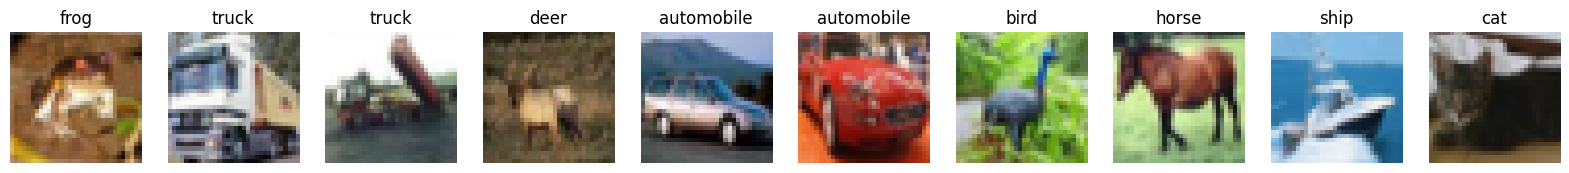

In [2]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load all the five training batches
training_images = []
training_labels = []
for i in range(1, 6):
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    training_images.append(batch_dict[b'data'])
    training_labels += batch_dict[b'labels']

# Reshape images
training_images = np.concatenate(training_images).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
training_labels = np.array(training_labels)

print("Training images shape:", training_images.shape)
print("Training labels shape:", training_labels.shape)

# Setup validation set
validation_batch = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
validation_images = validation_batch[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
validation_labels = np.array(validation_batch[b'labels'])

print("Validation images shape:", validation_images.shape)
print("Valudation labels shape:", validation_labels.shape)

# Display first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(training_images[i])
    plt.title(label_names[training_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()


### Apply One hot encoding

In [3]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded
train_labels_one_hot = to_categorical(training_labels, num_classes=10)
val_labels_one_hot = to_categorical(validation_labels, num_classes=10)

print(train_labels_one_hot.shape)
print(val_labels_one_hot.shape)

(50000, 10)
(10000, 10)


## Apply Data Augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_datagen.fit(training_images)
val_datagen.fit(validation_images)

# Prepare iterators for training and validation
train_generator = train_datagen.flow(training_images, train_labels_one_hot, batch_size=64, shuffle=True)
validation_generator = val_datagen.flow(validation_images, val_labels_one_hot, batch_size=64, shuffle=True)

## Model Architecture

In [10]:

def residual_block(inputs, filters, kernel_size, strides=(1, 1), use_conv_shortcut=False, weight_decay=1e-4, dropout_rate=0.3):
    shortcut = inputs
    padding = 'same'

    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    x = Dropout(dropout_rate)(x)  # Add dropout layer

    x = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = BatchNormalization()(x)  # Add batch normalization before activation
    x = Activation(swish)(x)
    x = Dropout(dropout_rate)(x)  # Add dropout layer

    if use_conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding=padding, kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = BatchNormalization()(x)  # Add batch normalization before activation
    x = Activation(swish)(x)

    return x

def build_resnet(input_shape, num_classes, weight_decay=1e-4):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = residual_block(x, 64, 3, use_conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 64, 3, weight_decay=weight_decay)
    x = residual_block(x, 64, 3, weight_decay=weight_decay)

    x = residual_block(x, 128, 3, strides=(2, 2), use_conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 128, 3, weight_decay=weight_decay)
    x = residual_block(x, 128, 3, weight_decay=weight_decay)

    x = residual_block(x, 256, 3, strides=(2, 2), use_conv_shortcut=True, weight_decay=weight_decay)
    x = residual_block(x, 256, 3, weight_decay=weight_decay)
    x = residual_block(x, 256, 3, weight_decay=weight_decay)

    x = Dropout(0.3)(x)  # Add dropout layer before Flatten
    #x = MaxPooling2D(pool_size=4)(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)  # Add dropout layer after Flatten
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = build_resnet(input_shape=(32, 32, 3), num_classes=10, weight_decay=1e-4)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_88[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_112      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_112[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_89[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_113      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 32, 32,    │          0 │ activation_113[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_80[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ batch_normalizat… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_114      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 32, 32,    │      4,160 │ activation_112[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 32, 32,    │          0 │ activation_114[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_91[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 32, 32,    │          0 │ dropout_81[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ add_36[0][0]    

 Total params: 4,352,330 (16.60 MB)

 Trainable params: 4,340,554 (16.56 MB)

 Non-trainable params: 11,776 (46.00 KB)

### Model Architecture Image

In [11]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture with reduced detail
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='TB')

## Model Training

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import CategoricalCrossentropy

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/782 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.1055 - loss: 2.7081    

I0000 00:00:1712948337.014619      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2947 - loss: 2.1580
Epoch 1: val_accuracy improved from -inf to 0.46840, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 173s 127ms/step - accuracy: 0.2950 - loss: 2.1572 - val_accuracy: 0.4684 - val_loss: 1.7937 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5780 - loss: 1.4030
Epoch 2: val_accuracy improved from 0.46840 to 0.58470, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.5780 - loss: 1.4029 - val_accuracy: 0.5847 - val_loss: 1.4557 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6556 - loss: 1.1983
Epoch 3: val_accuracy improved from 0.58470 to 0.64150, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.6556 - loss: 1.1983 - val_accuracy: 0.6415 - val_loss: 1.2742 - learning_rate: 0.0010
Epoch 4/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/ste

### Load the test batch

(10000, 32, 32, 3)


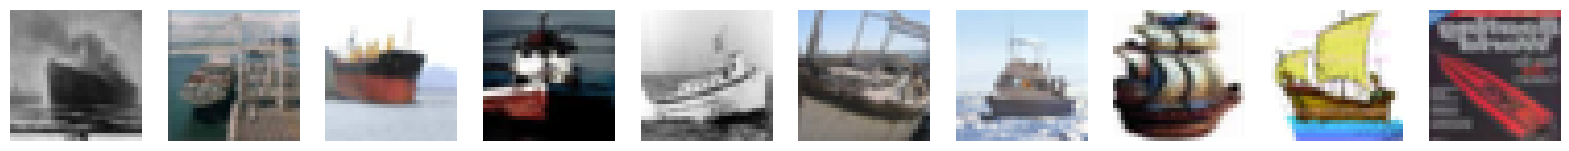

In [13]:
# Load the test batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')  # Update the path accordingly

# Adjust shape
images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32)
images = np.transpose(images, (0, 2, 3, 1))

print(images.shape)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i].astype(np.uint8))
    plt.axis('off')
plt.show()

### Normalize the images and predict with the model built

In [14]:
# Ensure the images are normalized
custom_test_images = images.astype('float32') / 255.0

# Predict with the model
predictions = model.predict(custom_test_images)

# Convert predictions to class labels if necessary
predicted_classes = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step


In [15]:
predicted_classes

array([8, 8, 8, ..., 3, 5, 8])

### Plotting Training vs Validation Accuracy

In [19]:
# Get the final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f'Final Training Accuracy: {train_acc:.4f}')
print(f'Final Validation Accuracy: {val_acc:.4f}')

Final Training Accuracy: 0.9739
Final Validation Accuracy: 0.9352


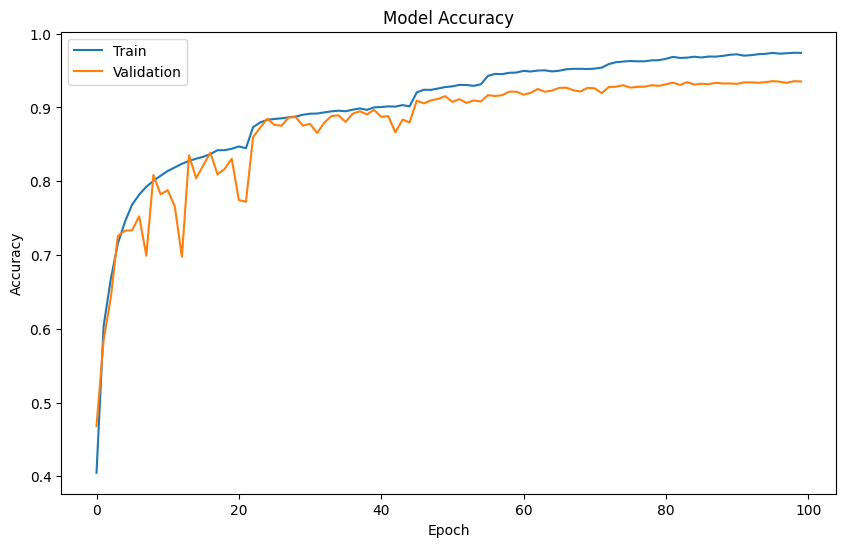

In [17]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Export the predictions into a csv file

In [18]:
# Convert predictions to label indices (if they are not already)
predicted_classes = predictions.argmax(axis=1)

# Create a DataFrame with ID and predicted labels
submission = pd.DataFrame({
    'ID': range(len(predicted_classes)),
    'Labels': predicted_classes
})

# Save the DataFrame to a CSV file, without the index
submission.to_csv('/kaggle/working/submission.csv', index=False)